# U-net with Resnet Blocks v3 and StratifiedKFold 
* Make the validation data distribution more close to train and possibly final test data
* For demonstration only, can use with previous  version or other models to get higher score: 

  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
  
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss     
        


In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

In [2]:
# total folds numbers for cross-validation
cv_total = 5
#cv_index = 1 -5

# model version
version = 1
basic_name_ori = f'Unet_resnet_v{version}'
save_model_name = basic_name_ori + '.model'
submission_file = basic_name_ori + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v1.model
Unet_resnet_v1.csv


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    return img
    
def downsample(img):# not used
    return img

## Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Loading a test DataFrame too with entries from depth not in train.

In [4]:
# data directory
data_dir = '../../input'

In [5]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col="id", usecols=[0])
depths_df = pd.read_csv(os.path.join(data_dir, "depths.csv"), index_col="id")

In [6]:
train_df.head(3)

""
id
575d24d81d
a266a2a9df
75efad62c1


In [7]:
depths_df.head(3)

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305


In [8]:
train_df = train_df.join(depths_df)
train_df.head(3)

,z
id,
575d24d81d,843
a266a2a9df,794
75efad62c1,468


In [9]:
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df), len(test_df)

(4000, 18000)

## Load images and their corresponding masks
load the image snad masks into the DataFrame and divide the pixel values by 255.

In [10]:
train_df["images"] = [np.array(load_img(os.path.join(data_dir, "train/images/{}.png".format(idx)), color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [11]:
train_df["masks"] = [np.array(load_img(os.path.join(data_dir, "train/masks/{}.png".format(idx)), color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

## Calculate the salt coverage and salt coverage classes
This mask type is used for stratify, the difficuly of training different mask type is different.

Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

* Reference  from Heng's discussion, search "error analysis" in the following link

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657****

In [12]:
#### Reference  from Heng's discussion
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657
def get_mask_type(mask, img_size=img_size_target, border=10):
    outer = np.zeros((img_size-2*border, img_size-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)

train_df["coverage_class"] = train_df.masks.map(get_mask_type)


## Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also shows an image to check for correct upsampling.

In [13]:
train_all = []
evaluate_all = []

# Stratified K-Folds cross-validator
# Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits=cv_total, random_state=1234, shuffle=True)
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3198,) (802,)
(3199,) (801,)
(3199,) (801,)
(3200,) (800,)
(3204,) (796,)


In [14]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

## Show  some examples of different mask

(3198,) (802,)
train cv1: number of each mask class = 
 	[[1279.  192.   84.  372.  179.  407.  334.  351.]]
evaluate cv1: number of each mask class = 
 	 [[320.  48.  22.  93.  45. 102.  84.  88.]]


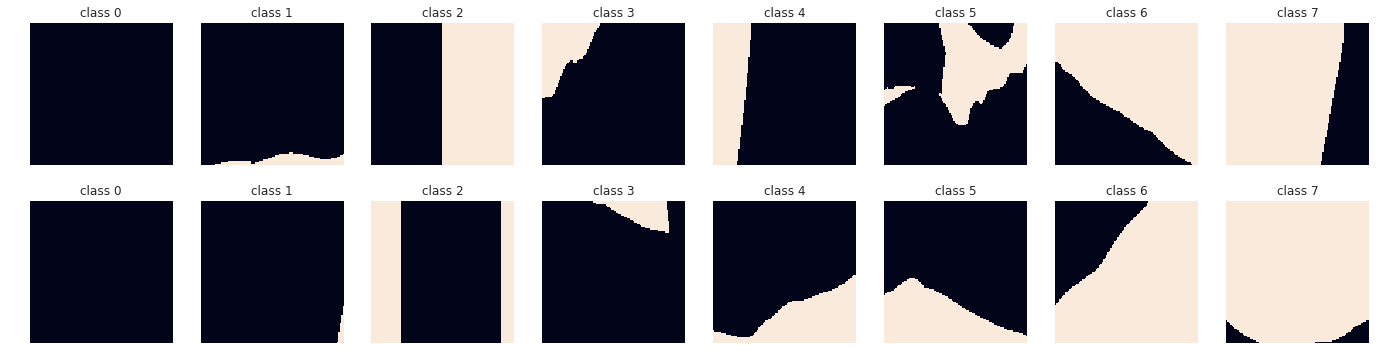

In [15]:
cv_index = 1

# for given fold index, obtain its indices for train/evaluation 
train_index = train_all[cv_index-1]
evaluate_index = evaluate_all[cv_index-1]

print(train_index.shape,evaluate_index.shape)

# for train
histall = histcoverage(train_df.coverage_class[train_index].values)
print(f'train cv{cv_index}: number of each mask class = \n \t{histall}')

# for evaluation
histall_test = histcoverage(train_df.coverage_class[evaluate_index].values)
print(f'evaluate cv{cv_index}: number of each mask class = \n \t {histall_test}')

# show mask class example
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 6), sharex=True, sharey=True)

# masks
for c in range(8):
    j= 0
    for i in train_index:
        if train_df.coverage_class[i] == c:
            axes[j,c].imshow(np.array(train_df.masks[i])  )
            axes[j,c].set_axis_off()
            axes[j,c].set_title(f'class {c}')
            j += 1
            if(j>=2):
                break

## Helper functions for Resnet blocks

In [16]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


## Resnet model

In [17]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

## helper metric functions 

In [18]:
def get_iou_vector(A, B):
    A = np.squeeze(A) 
    B = np.squeeze(B) 

    batch_size = A.shape[0]

    metric = []
    for ib in range(batch_size):

        t, p = A[ib]>0, B[ib]>0

        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue

        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue

        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0)  )/ (np.sum(union > 0) )

        thresholds = np.arange(0.5, 1, 0.05)

        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [19]:
def plot_history(history,metric_name):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(history.epoch, history.history[metric_name], label="Train score")
    ax_score.plot(history.epoch, history.history["val_" + metric_name], label="Validation score")
    ax_score.legend()

def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [20]:
def build_compile_model(lr = 0.01):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)

    model1 = Model(input_layer, output_layer)

    c = optimizers.Adam(lr = lr)
    model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    return model1

## Training

############################################
 Unet_resnet_v1_cv1
Train on 6396 samples, validate on 802 samples
Epoch 1/20

Epoch 00001: val_my_iou_metric improved from -inf to 0.35399, saving model to Unet_resnet_v1_cv1.model
 - 49s - loss: 13.0797 - my_iou_metric: 0.3902 - val_loss: 22.0849 - val_my_iou_metric: 0.3540
Epoch 2/20

Epoch 00002: val_my_iou_metric improved from 0.35399 to 0.37157, saving model to Unet_resnet_v1_cv1.model
 - 23s - loss: 10.6823 - my_iou_metric: 0.4846 - val_loss: 26.2050 - val_my_iou_metric: 0.3716
Epoch 3/20

Epoch 00003: val_my_iou_metric improved from 0.37157 to 0.38666, saving model to Unet_resnet_v1_cv1.model
 - 23s - loss: 9.4735 - my_iou_metric: 0.5238 - val_loss: 11.6259 - val_my_iou_metric: 0.3867
Epoch 4/20

Epoch 00004: val_my_iou_metric improved from 0.38666 to 0.59464, saving model to Unet_resnet_v1_cv1.model
 - 23s - loss: 8.6198 - my_iou_metric: 0.5406 - val_loss: 11.2745 - val_my_iou_metric: 0.5946
Epoch 5/20

Epoch 00005: val_my_iou_metri


Epoch 00001: val_my_iou_metric improved from -inf to 0.39012, saving model to Unet_resnet_v1_cv3.model
 - 76s - loss: 13.3815 - my_iou_metric: 0.3814 - val_loss: 37.6466 - val_my_iou_metric: 0.3901
Epoch 2/20

Epoch 00002: val_my_iou_metric improved from 0.39012 to 0.54306, saving model to Unet_resnet_v1_cv3.model
 - 23s - loss: 10.9663 - my_iou_metric: 0.5145 - val_loss: 13.8780 - val_my_iou_metric: 0.5431
Epoch 3/20

Epoch 00003: val_my_iou_metric did not improve from 0.54306
 - 22s - loss: 9.6876 - my_iou_metric: 0.5327 - val_loss: 18.9921 - val_my_iou_metric: 0.5268
Epoch 4/20

Epoch 00004: val_my_iou_metric did not improve from 0.54306
 - 22s - loss: 8.4365 - my_iou_metric: 0.5432 - val_loss: 18.5693 - val_my_iou_metric: 0.4612
Epoch 5/20

Epoch 00005: val_my_iou_metric did not improve from 0.54306

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
 - 25s - loss: 7.7731 - my_iou_metric: 0.5578 - val_loss: 30.8312 - val_my_iou_metric: 0.3645
Epoch 6/20

 - 24s - loss: 10.9253 - my_iou_metric: 0.4961 - val_loss: 20.0063 - val_my_iou_metric: 0.3918
Epoch 3/20

Epoch 00003: val_my_iou_metric improved from 0.39183 to 0.57249, saving model to Unet_resnet_v1_cv5.model
 - 24s - loss: 9.0541 - my_iou_metric: 0.5265 - val_loss: 11.8080 - val_my_iou_metric: 0.5725
Epoch 4/20

Epoch 00004: val_my_iou_metric improved from 0.57249 to 0.60980, saving model to Unet_resnet_v1_cv5.model
 - 24s - loss: 8.3415 - my_iou_metric: 0.5615 - val_loss: 11.2636 - val_my_iou_metric: 0.6098
Epoch 5/20

Epoch 00005: val_my_iou_metric did not improve from 0.60980
 - 23s - loss: 7.6750 - my_iou_metric: 0.5740 - val_loss: 7.8692 - val_my_iou_metric: 0.5617
Epoch 6/20

Epoch 00006: val_my_iou_metric improved from 0.60980 to 0.63128, saving model to Unet_resnet_v1_cv5.model
 - 24s - loss: 7.1848 - my_iou_metric: 0.5985 - val_loss: 7.7604 - val_my_iou_metric: 0.6313
Epoch 7/20

Epoch 00007: val_my_iou_metric did not improve from 0.63128
 - 23s - loss: 6.5973 - my_iou_me

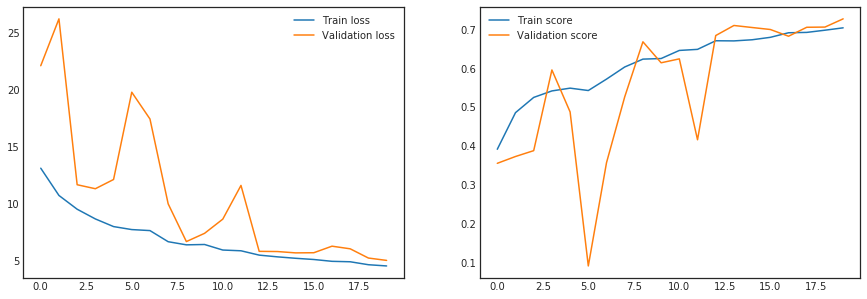

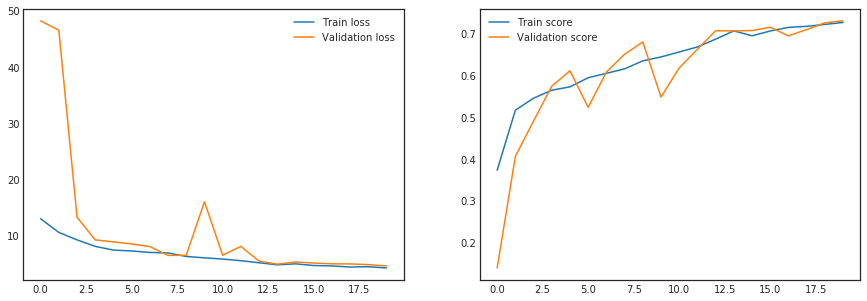

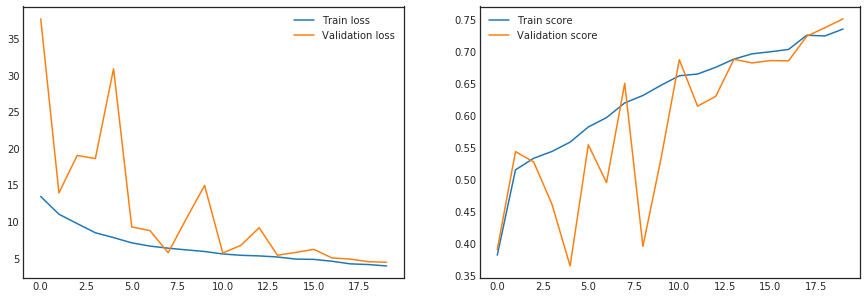

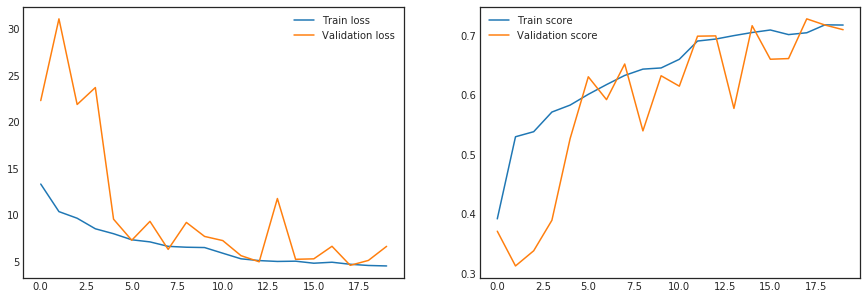

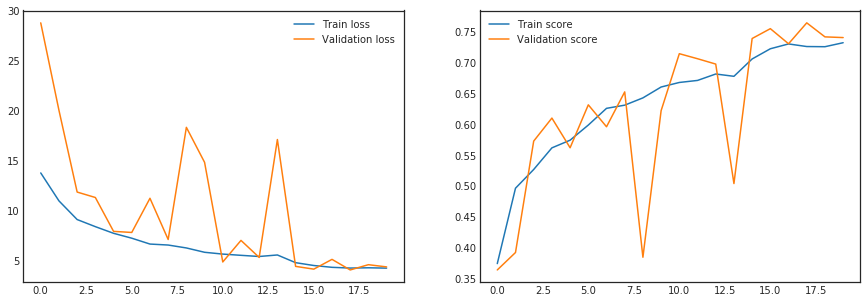

In [21]:
# training
ious = [0] * cv_total
for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    save_model_name = basic_name + '.model'
    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

    model = build_compile_model(lr = 0.01)

    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',
                                  factor=0.5, patience=3, min_lr=0.0001, verbose=1)

    epochs = 20 #small number for demonstration 
    batch_size = 32
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[ model_checkpoint,reduce_lr], 
                        verbose=2)
    plot_history(history,'my_iou_metric')
    
    model.load_weights(save_model_name)
    
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious[cv_index] = get_iou_vector(y_valid, (preds_valid > 0.5))
    
#model1.summary()

In [22]:
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious = {ious[cv_index]}")

cv 0 ious = 0.7314214463840399
cv 1 ious = 0.7423220973782774
cv 2 ious = 0.7503121098626716
cv 3 ious = 0.7367500000000001
cv 4 ious = 0.7657035175879398


## Test
Load, predict, and submit the test image predictions

In [23]:
x_test = np.array([(np.array(load_img(os.path.join(data_dir, "test/images/{}.png".format(idx)), color_mode='grayscale'))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)


In [24]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    model.load_weights(basic_name + '.model')
    preds_test += predict_result(model,x_test,img_size_target) /cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

Usedtime = 165.6633265018463 s


In [25]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:

t1 = time.time()
threshold  = 0.5 # some value in range 0.4- 0.5 may be better 
pred_dict = {idx: rle_encode(np.round(preds_test[i]) > threshold) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 1.582017421722412 s


In [27]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [28]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 0.8090659265385733 hours
